In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
import string
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/gaurav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def get_data(path, augmented = False):
    if augmented:
        df = pd.read_csv(path)
        df.dropna(subset=['reviewContent', 'label'], inplace=True)
        return df
    df = pd.read_csv(path)
    df.dropna(subset=['reviewContent', 'label'], inplace=True)
    df1 = df[df.label == 1]
    df2 = df[df.label == 0].sample(n=df1.shape[0], random_state=1)
    new_df = pd.concat([df1, df2], ignore_index=True)

    data = new_df.sample(frac=1, random_state=2)
    return data

In [3]:
# data = get_data('preReviewsCSV.csv', augmented=False)
data = get_data('augmentedReviewsCSV.csv', augmented=True)
# data = get_data('newCSV.csv', augmented=True)

In [4]:
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [5]:
x = data['reviewContent']
y = data['label']
print(x.shape, y.shape)
print(x.head())
print(y.head())

(93493,) (93493,)
0    torn mavin rate placeso ill give dinner party ...
1    good food �nice present �excel servic � come h...
2    doug sausag jedi mani place wait get long  pla...
3    im pig sleep with place place never buy someth...
4    eschew hourlong wait hell kitchen companion de...
Name: reviewContent, dtype: object
0    1
1    1
2    1
3    1
4    0
Name: label, dtype: int64


In [6]:
x[x.isna()]

Series([], Name: reviewContent, dtype: object)

Takes 2m 30s seconds

In [7]:
vocab = TfidfVectorizer(analyzer = text_process, max_features = 1000).fit(x)
print(f"Len of vocab: {len(vocab.vocabulary_)}")

Len of vocab: 50


Takes 2m 30s seconds

In [8]:
x = vocab.transform(x)
print(f"Shape of x: {x.shape}")

print(f"Non zero elements in x: {x.nnz}")

print(f"Density of x: {x.nnz / (x.shape[0] * x.shape[1]) * 100}")

Shape of x: (93493, 50)
Non zero elements in x: 796799
Density of x: 17.045104981121582


In [9]:
import pickle

In [10]:
with open('./Baselines/data/vectorizer_x.pkl', 'wb') as file:
    pickle.dump(x, file)
with open('./Baselines/data/vectorizer_y_label.pkl', 'wb') as file:
    pickle.dump(y, file)

In [11]:
with open('./Baselines/data/vectorizer_x.pkl', 'rb') as file:
    x = pickle.load(file)
with open('./Baselines/data/vectorizer_y_label.pkl', 'rb') as file:
    y = pickle.load(file)

In [30]:
print(x.shape, y.shape)

(93493, 50) (93493,)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

Takes 3 mins

In [14]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_train, y_train)
predrmfr = rmfr.predict(x_test)

print(f"Accuracy: {accuracy_score(y_test, predrmfr)}")

print("Confusion Matrix")
print(confusion_matrix(y_test, predrmfr))
print("Classification Report")
print(classification_report(y_test, predrmfr))

Accuracy: 0.8737900422482485
Confusion Matrix
[[8433  855]
 [1505 7906]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      9288
           1       0.90      0.84      0.87      9411

    accuracy                           0.87     18699
   macro avg       0.88      0.87      0.87     18699
weighted avg       0.88      0.87      0.87     18699



In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
predknn = knn.predict(x_test)

print(f"Accuracy: {accuracy_score(y_test, predknn)}")

print("Confusion Matrix")
print(confusion_matrix(y_test, predknn))
print("Classification Report")
print(classification_report(y_test, predknn))

Accuracy: 0.8168886036686454
Confusion Matrix
[[7147 2141]
 [1283 8128]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      9288
           1       0.79      0.86      0.83      9411

    accuracy                           0.82     18699
   macro avg       0.82      0.82      0.82     18699
weighted avg       0.82      0.82      0.82     18699



In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', random_state=1)
lr.fit(x_train, y_train)
predlr = lr.predict(x_test)

print(f"Accuracy: {accuracy_score(y_test, predlr)}")

print("Confusion Matrix")
print(confusion_matrix(y_test, predlr))
print("Classification Report")
print(classification_report(y_test, predlr))

Accuracy: 0.8105781057810578
Confusion Matrix
[[8037 1251]
 [2291 7120]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      9288
           1       0.85      0.76      0.80      9411

    accuracy                           0.81     18699
   macro avg       0.81      0.81      0.81     18699
weighted avg       0.81      0.81      0.81     18699



In [17]:
import torch
import torch.nn as nn

In [18]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNetworkModel, self).__init__()
        self.input_shape = input_shape
        self.model = nn.Sequential(
            nn.Linear(self.input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
type(x_train), type(torch.Tensor)

(scipy.sparse._csr.csr_matrix, torch._C._TensorMeta)

In [21]:
from torch.utils.data import Dataset, DataLoader

In [22]:
x_train.shape, y_train.shape, type(x_train)

((74794, 50), (74794,), scipy.sparse._csr.csr_matrix)

In [23]:
class ReviewsDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y.to_numpy()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        self.x_item = torch.tensor(self.x[idx].toarray().reshape(-1,), dtype = torch.float32)
        self.y_item = torch.tensor(self.y[idx], dtype = torch.float32)
        return self.x_item, self.y_item

In [24]:
BATCHSIZE = 512

In [25]:
train_dataset = ReviewsDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_dataset = ReviewsDataset(x_test, y_test)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)

In [26]:
from tqdm import tqdm

In [33]:
model = NeuralNetworkModel(x_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 25
for epoch in tqdm(range(n_epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (x_batch_train, y_batch_train) in enumerate(train_dataloader):
        x_batch_train, y_batch_train = x_batch_train.to(device), y_batch_train.to(device)
        model.train() 
        y_pred = model(x_batch_train).squeeze()
        # print(y_pred.shape, y_batch_train.shape)
        loss = criterion(y_pred, y_batch_train)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 1 == 0:
            print(f"Looked at {batch * len(x_batch_train)}/{len(train_dataloader.dataset)} samples", end = '\r')

    train_loss /= len(train_dataloader)
    
    ### Testing
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for x_batch_val, y_batch_val in val_dataloader:
            x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
            val_pred = model(x_batch_val).squeeze()
            y_pred = val_pred.round()
            test_loss += criterion(val_pred, y_batch_val) # accumulatively add up the loss per epoch
            test_acc += accuracy_score(y_batch_val.detach().to('cpu'), y_pred.detach().to('cpu'))
        
        test_loss /= len(val_dataloader)
        test_acc /= len(val_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
              

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
-------


  4%|▍         | 1/25 [00:03<01:25,  3.55s/it]


Train loss: 0.68712 | Test loss: 0.66957, Test acc: 0.68%

Epoch: 1
-------


  8%|▊         | 2/25 [00:07<01:20,  3.49s/it]


Train loss: 0.59575 | Test loss: 0.49834, Test acc: 0.79%

Epoch: 2
-------


 12%|█▏        | 3/25 [00:10<01:15,  3.45s/it]


Train loss: 0.44356 | Test loss: 0.42068, Test acc: 0.80%

Epoch: 3
-------


 16%|█▌        | 4/25 [00:14<01:13,  3.51s/it]


Train loss: 0.40880 | Test loss: 0.40559, Test acc: 0.81%

Epoch: 4
-------


 20%|██        | 5/25 [00:17<01:10,  3.51s/it]


Train loss: 0.39722 | Test loss: 0.39869, Test acc: 0.81%

Epoch: 5
-------


 24%|██▍       | 6/25 [00:20<01:06,  3.50s/it]


Train loss: 0.39199 | Test loss: 0.39230, Test acc: 0.81%

Epoch: 6
-------


 28%|██▊       | 7/25 [00:24<01:03,  3.50s/it]


Train loss: 0.38725 | Test loss: 0.38953, Test acc: 0.81%

Epoch: 7
-------


 32%|███▏      | 8/25 [00:28<00:59,  3.50s/it]


Train loss: 0.38488 | Test loss: 0.38612, Test acc: 0.81%

Epoch: 8
-------


 36%|███▌      | 9/25 [00:31<00:55,  3.49s/it]


Train loss: 0.38248 | Test loss: 0.38421, Test acc: 0.81%

Epoch: 9
-------


 40%|████      | 10/25 [00:35<00:52,  3.52s/it]


Train loss: 0.37955 | Test loss: 0.38235, Test acc: 0.81%

Epoch: 10
-------


 44%|████▍     | 11/25 [00:38<00:48,  3.50s/it]


Train loss: 0.37793 | Test loss: 0.38163, Test acc: 0.81%

Epoch: 11
-------


 48%|████▊     | 12/25 [00:41<00:45,  3.50s/it]


Train loss: 0.37657 | Test loss: 0.37998, Test acc: 0.81%

Epoch: 12
-------


 52%|█████▏    | 13/25 [00:45<00:41,  3.49s/it]


Train loss: 0.37503 | Test loss: 0.37790, Test acc: 0.82%

Epoch: 13
-------


 56%|█████▌    | 14/25 [00:48<00:38,  3.46s/it]


Train loss: 0.37404 | Test loss: 0.37722, Test acc: 0.82%

Epoch: 14
-------


 60%|██████    | 15/25 [00:52<00:34,  3.45s/it]


Train loss: 0.37192 | Test loss: 0.37518, Test acc: 0.82%

Epoch: 15
-------


 64%|██████▍   | 16/25 [00:55<00:31,  3.46s/it]


Train loss: 0.37212 | Test loss: 0.37492, Test acc: 0.82%

Epoch: 16
-------


 68%|██████▊   | 17/25 [00:59<00:27,  3.43s/it]


Train loss: 0.37094 | Test loss: 0.37417, Test acc: 0.82%

Epoch: 17
-------


 72%|███████▏  | 18/25 [01:02<00:24,  3.44s/it]


Train loss: 0.37023 | Test loss: 0.37259, Test acc: 0.82%

Epoch: 18
-------


 76%|███████▌  | 19/25 [01:06<00:20,  3.46s/it]


Train loss: 0.36830 | Test loss: 0.37231, Test acc: 0.82%

Epoch: 19
-------


 80%|████████  | 20/25 [01:09<00:17,  3.46s/it]


Train loss: 0.36747 | Test loss: 0.37117, Test acc: 0.82%

Epoch: 20
-------


 84%|████████▍ | 21/25 [01:13<00:13,  3.46s/it]


Train loss: 0.36878 | Test loss: 0.37024, Test acc: 0.82%

Epoch: 21
-------


 88%|████████▊ | 22/25 [01:16<00:10,  3.48s/it]


Train loss: 0.36569 | Test loss: 0.36937, Test acc: 0.82%

Epoch: 22
-------


 92%|█████████▏| 23/25 [01:19<00:06,  3.47s/it]


Train loss: 0.36569 | Test loss: 0.36931, Test acc: 0.82%

Epoch: 23
-------


 96%|█████████▌| 24/25 [01:23<00:03,  3.47s/it]


Train loss: 0.36437 | Test loss: 0.36933, Test acc: 0.82%

Epoch: 24
-------


100%|██████████| 25/25 [01:26<00:00,  3.48s/it]


Train loss: 0.36346 | Test loss: 0.36827, Test acc: 0.82%



In [34]:
from ml_things import plot_confusion_matrix

Accuracy: 0.8210599497299321
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      9288
           1       0.86      0.77      0.81      9411

    accuracy                           0.82     18699
   macro avg       0.82      0.82      0.82     18699
weighted avg       0.82      0.82      0.82     18699

Normalized confusion matrix


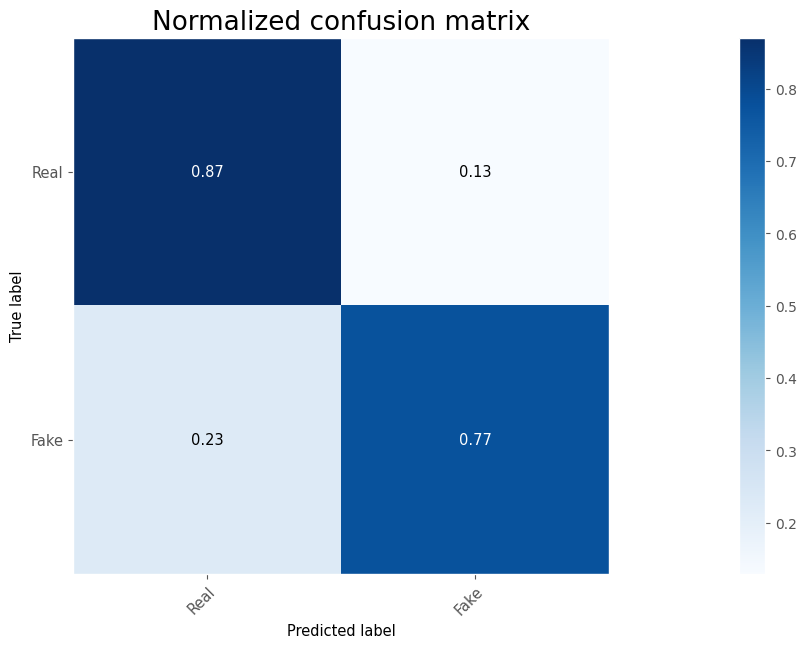

array([[0.8705857 , 0.1294143 ],
       [0.22781851, 0.77218149]])

In [35]:
model.eval()
all_preds = []
all_label_ids = []

with torch.inference_mode():
    for x_batch_val, y_batch_val in val_dataloader:
        x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
        val_pred = model(x_batch_val).squeeze()
        y_pred = val_pred.round()

        all_preds.extend(y_pred.detach().to('cpu').numpy())
        all_label_ids.extend(y_batch_val.detach().to('cpu').numpy())

all_preds = np.array(all_preds)
all_label_ids = np.array(all_label_ids)

print(f"Accuracy: {accuracy_score(all_label_ids, all_preds)}")

evaluation_report = classification_report(all_label_ids, all_preds, labels=[0, 1])
print(evaluation_report)

plot_confusion_matrix(y_true=all_label_ids, y_pred=all_preds, 
                      classes=['Real', 'Fake'], normalize=True, 
                      magnify=0.1,
                      )